In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
testset = pd.read_csv('../Data/01_raw/attrition_test.csv', low_memory = False)
trainset = pd.read_csv('../Data/01_raw/attrition_train.csv', low_memory = False)

## Data exploratory

In [3]:
trainset.shape

(1100, 35)

In [4]:
trainset.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [5]:
trainset['Attrition'].value_counts()

No     922
Yes    178
Name: Attrition, dtype: int64

In [6]:
trainset = trainset.dropna()

In [7]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

trainset[['Attrition']] = enc.fit_transform(trainset[['Attrition']])

In [8]:
trainset = trainset.select_dtypes(exclude=['object'])

In [9]:
trainset.dtypes

Age                           int64
Attrition                   float64
DailyRate                     int64
DistanceFromHome              int64
Education                     int64
EmployeeCount                 int64
EmployeeNumber                int64
EnvironmentSatisfaction       int64
HourlyRate                    int64
JobInvolvement                int64
JobLevel                      int64
JobSatisfaction               int64
MonthlyIncome                 int64
MonthlyRate                   int64
NumCompaniesWorked            int64
PercentSalaryHike             int64
PerformanceRating             int64
RelationshipSatisfaction      int64
StandardHours                 int64
StockOptionLevel              int64
TotalWorkingYears             int64
TrainingTimesLastYear         int64
WorkLifeBalance               int64
YearsAtCompany                int64
YearsInCurrentRole            int64
YearsSinceLastPromotion       int64
YearsWithCurrManager          int64
dtype: object

In [10]:
trainset.head(5)

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,38,0.0,240,2,4,1,803,1,75,4,...,4,80,0,17,2,3,15,7,4,12
1,52,0.0,322,28,2,1,1401,4,59,4,...,2,80,1,24,3,2,5,3,0,2
2,28,0.0,1476,1,3,1,1315,3,55,1,...,1,80,3,10,6,3,9,8,7,5
3,43,0.0,920,3,3,1,1255,3,96,1,...,2,80,1,25,2,3,8,7,0,7
4,27,0.0,443,3,3,1,850,4,50,3,...,3,80,3,0,6,2,0,0,0,0


## TrainTest - Encodage - Nettoyage

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def encodage(df):
    numerical_cols=df.select_dtypes(np.number)
    numerical_transformer = SimpleImputer(strategy='median')

    categorical_cols=df.select_dtypes(include='object')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
        
    return df

In [12]:
def imputation(df):
    df = df.dropna(axis=0)
    return df

In [13]:
trainset = encodage(trainset)
trainset = imputation(trainset)
    
X = trainset.drop('Attrition', axis=1)
y = trainset['Attrition']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Modelisation

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [16]:
# SVC_params = {'svc__gamma': 0.005, 
#                 'svc__C': 30, 
#                 'svc__kernel' : 'rbf', 
#                }

# RF_params = {'max_depth': 6,
#                 'n_estimators': 100, 
#                 'min_samples_split': 10,
#                 'min_samples_leaf': 5, 
#                 'criterion': 'entropy' 
#                }

# Ada_params = {'n_estimators': 100, 
#               'learning_rate': 0.1 
#                 }

# KNN_params = {'kneighborsclassifier__n_neighbors': 15,
#                 }

In [17]:
RandomForest = RandomForestClassifier(max_depth = 6, n_estimators = 100, min_samples_split = 10, min_samples_leaf = 5, criterion = 'entropy', random_state= 0)
AdaBoost = AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100, random_state=0)
SVC = make_pipeline(StandardScaler(), SVC(gamma=0.005, C = 30, kernel = 'rbf', random_state=0, probability = True))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 15))

In [18]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import f1_score, confusion_matrix, classification_report
# from sklearn.feature_selection import RFECV


# def random_search(model, params, scoring = 'accuracy', cv = 3, n_iter = 50):
#     grid = RandomizedSearchCV(model, params, scoring = scoring, cv = cv, n_iter = n_iter, random_state=0)
#     grid.fit(X_train, y_train)
#     print(grid.best_params_)

#     y_pred = grid.predict(X_test)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
#     print('Train ROC AUC SCORE : {}'.format(roc_auc_score(y_train, grid.predict_proba(X_train)[:, 1])))
#     print('Test ROC AUC SCORE : {}'.format(roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])))

In [19]:
def new_search(model):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print('Train ROC AUC SCORE : {}'.format(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])))
    print('Test ROC AUC SCORE : {}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
    print('\n')
    
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [y_pred[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import RFECV

[[184   0]
 [ 36   0]]
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       184
         1.0       0.00      0.00      0.00        36

    accuracy                           0.84       220
   macro avg       0.42      0.50      0.46       220
weighted avg       0.70      0.84      0.76       220

Train ROC AUC SCORE : 0.9582713080651933
Test ROC AUC SCORE : 0.7119565217391304




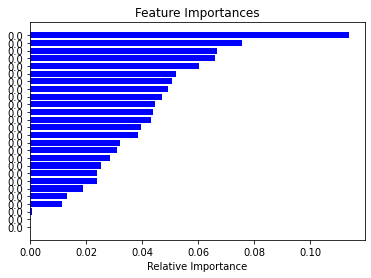

In [21]:
new_search(RandomForest)

[[184   0]
 [ 35   1]]
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       184
         1.0       1.00      0.03      0.05        36

    accuracy                           0.84       220
   macro avg       0.92      0.51      0.48       220
weighted avg       0.87      0.84      0.77       220

Train ROC AUC SCORE : 0.8550660330546968
Test ROC AUC SCORE : 0.7235054347826088




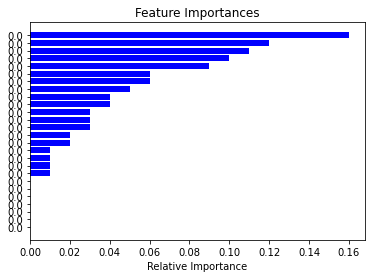

In [22]:
new_search(AdaBoost)

In [23]:
new_search(KNN)

[[184   0]
 [ 36   0]]
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       184
         1.0       0.00      0.00      0.00        36

    accuracy                           0.84       220
   macro avg       0.42      0.50      0.46       220
weighted avg       0.70      0.84      0.76       220

Train ROC AUC SCORE : 0.8365586472766137
Test ROC AUC SCORE : 0.5910326086956522




AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [42]:
new_search(SVC)

[[179   5]
 [ 30   6]]
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       184
         1.0       0.55      0.17      0.26        36

    accuracy                           0.84       220
   macro avg       0.70      0.57      0.58       220
weighted avg       0.81      0.84      0.80       220

Train ROC AUC SCORE : 0.9027539219054161
Test ROC AUC SCORE : 0.7435084541062802




AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [25]:
from sklearn.feature_selection import RFECV

selector = RFECV(SVC, step=1, cv=5)
selector = selector.fit(X, y)
print(selector.support_)

ValueError: when `importance_getter=='auto'`, the underlying estimator Pipeline should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.